In [4]:
#!pip install wordcloud
#!pip install tensorflow_hub
#!pip install tensorflow_text
#!pip uninstall tensorflow

^C


In [2]:
import pandas as pd
import random
import numpy as np
import os, math

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
 
#for text cleaning
import string, re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
 
#for data analysis and modeling
import tensorflow as tf
import tensorflow_hub as hub

# !pip install tensorflow_text
#import tensorflow_text 
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prabi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prabi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (C:\Users\prabi\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

In [11]:
disaster_train_data = pd.read_csv('bonus_train_data-1.csv')
disaster_test_data = pd.read_csv('bonus_test_data-1.csv')

In [13]:
disaster_train_data

,text,target
0,Courageous and honest analysis of need to use ...,1
1,@ZachZaidman @670TheScore wld b a shame if tha...,0
2,Tell @BarackObama to rescind medals of 'honor'...,1
3,Worried about how the CA drought might affect ...,1
4,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0
...,...,...
6085,@Eganator2000 There aren't many Obliteration s...,0
6086,just had a panic attack bc I don't have enough...,0
6087,Omron HEM-712C Automatic Blood Pressure Monito...,0
6088,Officials say a quarantine is in place at an A...,1


In [14]:
disaster_test_data

,text,target
0,So you have a new weapon that can cause un-ima...,1
1,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,Aftershock back to school kick off was great. ...,0
4,in response to trauma Children of Addicts deve...,0
...,...,...
1518,@SmusX16475 Skype just crashed u host,0
1519,Christian Attacked by Muslims at the Temple Mo...,1
1520,Man charged over fatal crash near Dubbo refuse...,1
1521,#usNWSgov Severe Weather Statement issued Augu...,1


In [15]:
disaster_train_data.shape, disaster_test_data.shape

((6090, 2), (1523, 2))

In [16]:
max_len_train = max(disaster_train_data['text'].apply(lambda x: len(x.split())).values)
max_len_test = max(disaster_train_data['text'].apply(lambda x: len(x.split())).values)
max_len_train, max_len_test

(31, 31)

target
0    3468
1    2622
Name: count, dtype: int64

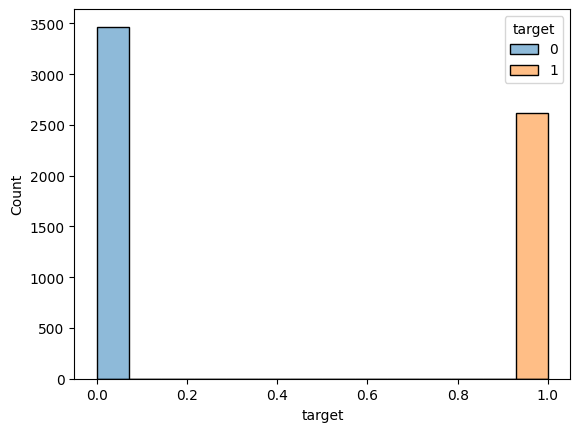

In [20]:
sns.histplot(data=disaster_train_data, x='target', hue='target')
disaster_train_data['target'].value_counts()

top 10 words: ['fire', 'new', 'disaster', 'california', 'suicide', 'via', 'u', 'people', 'amp', 'train']


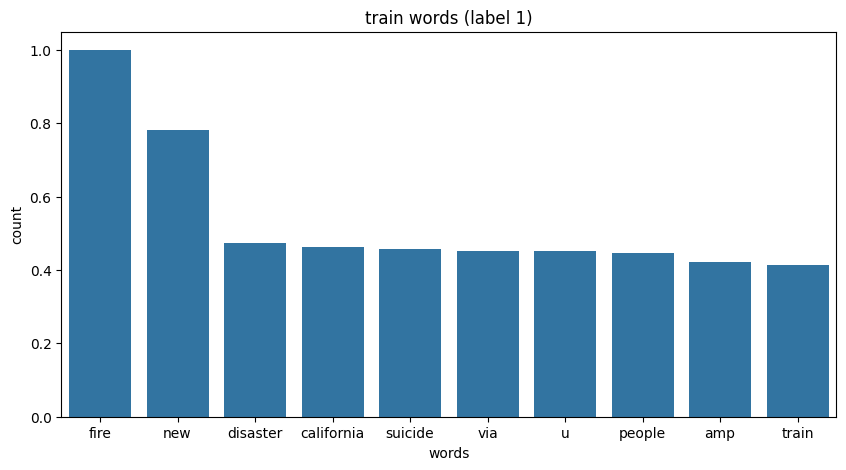

top 10 words: ['im', 'new', 'amp', 'u', 'one', 'time', 'body', 'via', 'video', 'people']


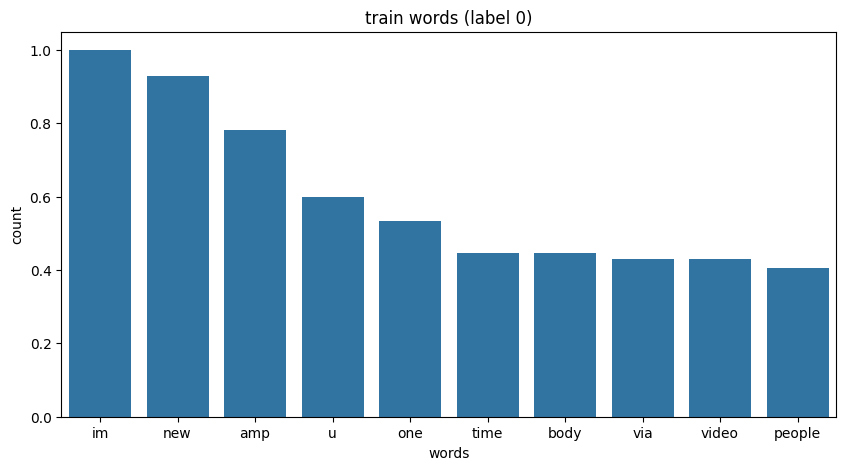

In [27]:
def plot_wordcloud(text, title, k=10):
  # Create and Generate a Word Cloud Image
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  # top k words
  plt.figure(figsize=(10,5))
  print(f'top {k} words: {list(wordcloud.words_.keys())[:k]}')
  ax = sns.barplot(x=0, y=1, data=pd.DataFrame(wordcloud.words_.items()).head(k))
  ax.set(xlabel = 'words', ylabel='count', title=title)
  plt.show()
  #Display the generated image
  # plt.figure(figsize=(15,15))
  # plt.imshow(wordcloud, interpolation="bilinear"), plt.title(title, size=20), plt.axis("off")
  # plt.show()
 
plot_wordcloud(' '.join(disaster_train_data[disaster_train_data['target']==1]['text'].values), 'train words (label 1)')
plot_wordcloud(' '.join(disaster_train_data[disaster_train_data['target']==0]['text'].values), 'train words (label 0)')

In [26]:

def clean_text(txt):
    """""
    cleans the input text by following the steps:
    * replace contractions
    * remove punctuation
    * split into words
    * remove stopwords
    * remove leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                        "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                        "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have"}
    
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re
 
    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)
 
    # replace contractions
    txt = replace_contractions(txt)
     
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    #remove numbers
    txt = re.sub('[0-9]+', '', txt)
    #txt = txt.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ", regex = True )
    txt = txt.lower() # lowercase
    txt = txt.replace(r"\#","") # replaces hashtags
    txt = txt.replace(r"http\S+","URL" )  # remove URL addresses
    txt = txt.replace(r"@","")
    txt = txt.replace("\s{2,}", " " ) # remove multiple contiguous spaces
     
    # split into words
    words = word_tokenize(txt)
     
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
     
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
     
    cleaned_text = ' '.join(words)
    return cleaned_text
 
# clean train and test tweets
disaster_train_data['text'] = disaster_train_data['text'].apply(lambda txt: clean_text(txt))
disaster_train_data['text'] = disaster_train_data['text'].apply(lambda txt: clean_text(txt))
 
disaster_train_data.head()

,text,target
0,courageous honest analysis need use atomic bom...,1
1,zachzaidman thescore wld b shame golf cart bec...,0
2,tell barackobama rescind medals honor given us...,1
3,worried ca drought might affect extreme weathe...,1
4,youngheroesid lava blast amp power red panther...,0


top 10 words: ['fire', 'new', 'disaster', 'california', 'suicide', 'via', 'u', 'people', 'amp', 'train']


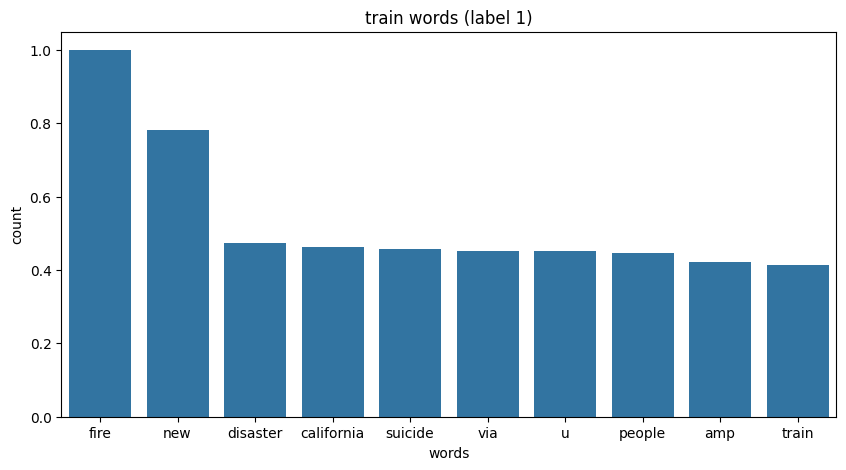

top 10 words: ['im', 'new', 'amp', 'u', 'one', 'time', 'body', 'via', 'video', 'people']


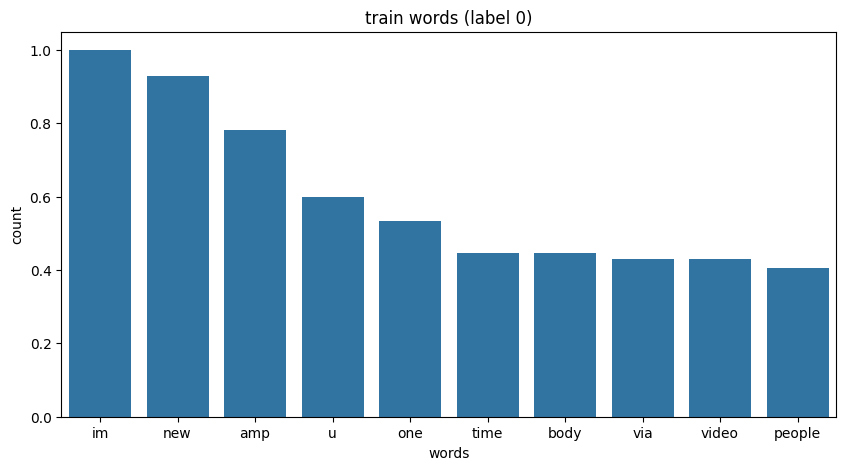

In [28]:
plot_wordcloud(' '.join(disaster_train_data[disaster_train_data['target']==1]['text'].values), 'train words (label 1)')
plot_wordcloud(' '.join(disaster_train_data[disaster_train_data['target']==0]['text'].values), 'train words (label 0)')

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(disaster_train_data['text'].values, disaster_train_data['target'].values, shuffle=True, test_size=0.2)
 
max_len = max(disaster_train_data['text'].apply(lambda x: len(x.split())).values)
max_words = 20000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)
 
# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index
 
print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])
 
# text example: Witness video shows car explode behind burning buildings nd St afternoon Manchester httptcocgmJlSEYLo via 
# MikeCroninWMUR
# sequence of indices(before padding): [17, 29, 37, 9]
# sequence of indices(after padding): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  17 29 37  9]


text example: californians like living africas sahel desert finding water daily chore httptcoysgvsrtg
sequence of indices(before padding): [4674, 1, 1184, 4675, 4676, 3034, 3035, 100, 521, 4677, 4678]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0 4674    1
 1184 4675 4676 3034 3035  100  521 4677 4678]


In [64]:
#!pip install wget
#!pip install unzip

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement ZipFile (from versions: none)
ERROR: No matching distribution found for ZipFile


In [65]:
#https://nlp.stanford.edu/projects/glove/
#import wget
#import unzip

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#download_file = wget.download(url)

#unzip g*zip

# importing the zipfile module 
#from zipfile import ZipFile 

#file_path ="glove.6B.zip"
#unzip.unzip(file_path)

#zipfile.extractall(file_path)
                   
%time
embedding_vectors = {}
with open('glove.6B.300d.txt','r',encoding='utf-8') as file: #glove.42B.300d.txt
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")  
 
# Size of vocabulary in GloVe: 400000
# CPU times: user 33.1 s, sys: 1.55 s, total: 34.7 s
# Wall time: 33.4 s

CPU times: total: 0 ns
Wall time: 0 ns
Size of vocabulary in GloVe: 400000


In [38]:
#initialize the embedding_matrix with zeros
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')
 
# Some out of valubulary words: []
# 0 out of 50 words were OOV.

Some out of valubulary words: ['like', 'amp', 'im', 'fire', 'get']
15569 out of 20000 words were OOV.


In [39]:
model_lstm = Sequential(name='model_lstm')
model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
#model_lstm.add(Embedding(vocab_len, emb_dim, trainable = True))
model_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_lstm.add(Dense(128, activation='relu'))
#model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(Dropout(0.2)) # Adding Dropout layer with rate of 0.2
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model_lstm.summary()

Model: "model_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [40]:
emb_dim = embedding_matrix.shape[1]
model_gru = Sequential(name='model_gru')
model_gru.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation = 'sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "model_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [43]:
# Define Embedding layer as pre-processing layer for tokenization
max_features = 20000 #  20000 most frequent words in the input text data.
 
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=200, output_mode='int') 
vectorizer.adapt(np.hstack((xtrain, xtest))) 
vectorizerd_text = vectorizer(xtrain)
 
dataset = tf.data.Dataset.from_tensor_slices((vectorizerd_text, ytrain))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32) 
dataset = dataset.prefetch(8)
batch_X, batch_y = dataset.as_numpy_iterator().next()
 
train = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))
 
model_bilstm = Sequential(name='model_bilstm')
model_bilstm.add(Embedding(max_features + 1, 64))
model_bilstm.add(Bidirectional(LSTM(64, activation='tanh')))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dropout(0.2)) # Adding Dropout layer with dropout rate of 0.2
model_bilstm.add(Dense(256, activation='relu'))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=[Recall()])
model_bilstm.summary()

Model: "model_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
xtrain

array(['californians like living africas sahel desert finding water daily chore httptcoysgvsrtg',
       'dont miss chris appys detonation myths obscuring crime hiroshima yrs ago month salon httptcodlpkpktk',
       'thunder pounds north goes black deep bruise skys chest wind cries pain summer storm tough life short violent',
       ...,
       'earthquake occurred near mount st helens area washington utc earthquake httptcoxmdidgpnr',
       'youngheroesid lava blast dan power red pantherattack cunayyh taufikcj',
       'campsite recommendations toilets shower pub fires kids pizza shop forest pretty stream midges snakes thanks'],
      dtype=object)

In [ ]:
def get_BERT_model():
    # Preprocessing
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    # Bert encoder
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
    x = bert_preprocess_model(input_layer)
    x = bert_model(x)['pooled_output']
    x = tf.keras.layers.Dropout(0.5)(x) #Optional, to eliminate overfitting
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    classification_out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
    bert_preprocess_model._name = "preprocess"
    bert_model._name = "bert_encoder"
    model_bert = tf.keras.Model(input_layer, classification_out)
    model_bert._name = "model_bert"
    return model_bert
 
model_bert = get_BERT_model()
model_bert.summary()

In [46]:
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")
 
model_use = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
], name = 'transfer_mode')
model_use.summary()

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x000001AB89964690> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [47]:
# model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
# with pretrained GloVe weights
%time
batch_size = 32
epochs  = 50
history = model_lstm.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.4985 - loss: 0.6919 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6868 - val_recall: 0.0000e+00
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.5020 - loss: 0.6884 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6833 - val_recall: 0.0000e+00
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.5000 - loss: 0.6869 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6812 - val_recall: 0.0000e+00
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.5009 - loss: 0.6860 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6800 - val_recall: 0.0000e+00
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.4973 - loss: 0.6848 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6792 - val_recall: 0.0000e+00
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.4862 - loss: 0.6834 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.6787 - 

In [48]:
batch_size = 32
epochs  = 50
history = model_gru.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5429 - loss: 0.6879 - val_accuracy: 0.5903 - val_loss: 0.6776
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5580 - loss: 0.6876 - val_accuracy: 0.5903 - val_loss: 0.6776
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5552 - loss: 0.6884 - val_accuracy: 0.5903 - val_loss: 0.6787
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5693 - loss: 0.6838 - val_accuracy: 0.5903 - val_loss: 0.6790
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5616 - loss: 0.6867 - val_accuracy: 0.5903 - val_loss: 0.6787
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5683 - loss: 0.6843 - val_accuracy: 0.5903 - val_loss: 0.6803
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5639 - loss: 0.6855 - val_accuracy: 0.5903 - val_loss: 0.6783
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5632 - loss: 0.6863 - val_accu

In [49]:
hist= model_bilstm.fit(train, epochs=30, batch_size=32, validation_data=val)

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.6556 - recall_1: 0.1606 - val_loss: 0.3490 - val_recall_1: 0.6803
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.3151 - recall_1: 0.7752 - val_loss: 0.2017 - val_recall_1: 0.9014
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.1663 - recall_1: 0.9188 - val_loss: 0.0833 - val_recall_1: 0.9585
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0767 - recall_1: 0.9594 - val_loss: 0.0565 - val_recall_1: 0.9698
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.7805 - recall_1: 0.7809 - val_loss: 0.0766 - val_recall_1: 0.9838
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0737 - recall_1: 0.9715 - val_loss: 0.0467 - val_recall_1: 0.9858
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0603 - recall_1: 0.9776 - val_loss: 0.0353 - val_recall_1: 0.9976
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0282 - recall_1: 0.9920 - val_los

<Figure size 1000x600 with 0 Axes>

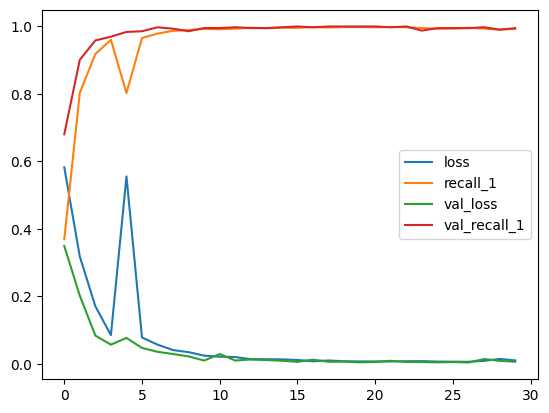

In [50]:
plt.figure(figsize=(10, 6))
pd.DataFrame(hist.history).plot()
plt.show()

In [ ]:
vectorizerd_test_text = vectorizer(X_test)
preds = []
for input_text in vectorizerd_test_text:    
    pred = model.predict(np.expand_dims(input_text, 0))    
    preds.append(pred)
 
preds = np.round(np.array(preds))
sub_sample = pd.read_csv('sample_submission.csv')
sub_sample['target'] = preds.flatten()
sub_sample['target'] = sub_sample['target'].astype('int')
sub_sample.to_csv('submission.csv', index=False)

In [51]:
class_weights = compute_class_weight(class_weight = "balanced", 
                                     classes = np.unique(disaster_train_data["target"]),
                                     y= disaster_train_data["target"])
class_weights = {k:class_weights[k] for k in np.unique(disaster_train_data["target"])}
class_weights
# {0: 0.8766697374481806, 1: 1.1637114032405993}

{0: 0.8780276816608996, 1: 1.1613272311212814}

In [52]:
epochs = 20
batch_size = 32
 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) #logits = data come forom direct output without sigmoid.
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
 
model_bert.get_layer('bert_encoder').trainable = True # need to train
 
model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)
 
train_data = disaster_train_data.sample(frac=0.8,random_state=200)
valid_data = disaster_train_data.drop(train_data.index)
 
history = model_bert.fit(x=disaster_train_data.text.values, 
                                          y=disaster_train_data.target.values,
                                          class_weight=class_weights,
                                          epochs=epochs,
                                          batch_size = batch_size,
                                          validation_data=(valid_data.text.values, valid_data.target.values))

NameError: name 'model_bert' is not defined

In [53]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history['val_binary_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()
 
plot_hist(history)

KeyError: 'binary_accuracy'

In [ ]:
X_test = df_test["text"].values
predictions_prob = model_bert.predict(X_test)
predictions = tf.round(predictions_prob)
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission2.csv', index=False)
submission.head()

In [ ]:
X, y = df_train['text'].values, df_train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, y.shape
# ((7613,), (7613,))
 
model_use.compile(loss = tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy',tf.keras.metrics.AUC()])

In [ ]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()
     
plot_hist(history)

In [ ]:
X_test = df_test['text'].values
predictions_prob = model_use.predict(X_test)
predictions = tf.round(predictions_prob)

In [ ]:
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission.csv', index=False)
submission.head()